# Categorizing Customer Inquiries Using SBERT and DBSCAN

In this project, we aim to automatically categorize customer inquiries using an unsupervised learning approach. Since these inquiries contain unstructured text, we use Sentence-BERT (SBERT) embeddings to transform the text into meaningful numerical representations, followed by DBSCAN clustering to identify distinct inquiry topics.

**SBERT (Sentence-BERT) for Embeddings**

- Converts customer conversations into high-dimensional vectors (384D) while preserving contextual meaning.
- Works better than traditional techniques like TF-IDF because it captures semantic similarity between sentences.

**DBSCAN (Density-Based Spatial Clustering)**

- Automatically identifies clusters without needing a predefined number of categories (unlike K-Means).
- Groups similar inquiries together based on density, making it ideal for discovering natural topics in customer conversations.
- Can filter out noise (Cluster -1), which helps remove outliers and irrelevant messages.

>[Categorizing Customer Inquiries Using SBERT and DBSCAN](#scrollTo=yWMW5VKUD1rp)

>>[Imports](#scrollTo=PXuB3oHgtZoi)

>>[Load Data](#scrollTo=O1MzVqxWu_lx)

>>[Embedding](#scrollTo=XAJr2M3Q05Qq)

>>[Clustering with DBSCAN](#scrollTo=E0taICRJ6ZiD)

>>[DBSCAN Clustering](#scrollTo=tVEwbNv8HT9L)

>>>[Labeling Clusters](#scrollTo=-O6lm6dFWXuB)

>>[Save The Final Dataset](#scrollTo=Qxzk6yZuX_7n)

>>[Summary](#scrollTo=E9sit6uOO1h1)



## Imports

In [1]:
!pip uninstall -y sentence-transformers huggingface_hub
!pip install -q --upgrade huggingface_hub
!pip install -q sentence-transformers
!pip install nltk
!pip install umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('stopwords')

import re

Found existing installation: sentence-transformers 3.4.1
Uninstalling sentence-transformers-3.4.1:
  Successfully uninstalled sentence-transformers-3.4.1
Found existing installation: huggingface-hub 0.28.1
Uninstalling huggingface-hub-0.28.1:
  Successfully uninstalled huggingface-hub-0.28.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s e

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Load Data

In [4]:
# Define the dataset path
data_path = 'drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/cleaned_data.csv'

In [5]:
# Load the dataset
df = pd.read_csv(data_path)

In [6]:
# Display the size of the dataset: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}\n\n")
df.head()

Number of features: 3




,conversation_id,utterance,sentiment_score
0,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,agent: hey may help today customer: hi want ch...,0.9896
1,acs-000e0b37-c8f0-46fe-9ffb-0c727e888339-1,agent: hellohow may help today customer: hi ne...,0.9977
2,acs-000efddb-1d74-4422-808e-1b4ccbf988f1-1,customer: good morning agent: good morning may...,0.9926
3,acs-001df2c1-5318-4715-8d99-7ece76c95fa2-1,agent: hello customer: hello jamie customer: n...,0.9961
4,acs-002c64ef-f434-41cd-8c36-39c4d8b9cd30-1,customer: hi agent: hello may help today custo...,0.9943


## Embedding

In [7]:
# Intitialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(df['utterance'])

print(f"Embeddings shape: {embeddings.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings shape: (8832, 384)


In [8]:
# Save embeddings
np.save('drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/embeddings.npy', embeddings)

## Clustering with DBSCAN

In [9]:
# Load the embedding file
embeddings = np.load('drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/embeddings.npy')

In [10]:
# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Check the average similarity score
avg_similarity = np.mean(similarity_matrix)
print(f"Average Similarity Score: {avg_similarity:.2f}")


Average Similarity Score: 0.72


**Reducing SBERT Embeddings to 10D**
After computing SBERT embeddings (384D) and applying DBSCAN, the clustering results showed:
- Too many inquiries grouped into a single cluster
- Many points were classified as outliers (-1 cluster)

To improve clustering, we applied UMAP to reduce the embedding dimensions from 384D to 10D.

In [11]:
# Reduce SBERT embeddings to 10D
umap_model = umap.UMAP(n_components=10, random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# Check new shape
print(reduced_embeddings.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8832, 10)


In [12]:
# Save the reduced embeddings
np.save('drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/reduced_embeddings.npy', reduced_embeddings)

In [13]:
# Load the reduced embeddings file
reduced_embeddings = np.load('drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/reduced_embeddings.npy')

## DBSCAN Clustering

In [14]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.6, min_samples=5, metric='euclidean')
cluster_labels = dbscan.fit_predict(reduced_embeddings)

# Add cluster label to dataset
df['cluster'] = cluster_labels

# Display cluster counts
df['cluster'].value_counts()

,count
cluster,
0,3160
2,2749
1,2178
5,304
3,263
4,152
6,26


In [15]:
# Show first 5 messages per cluster
pd.set_option('display.max_colwidth', None)  # Show full text

for cluster in set(cluster_labels):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster'] == cluster]['utterance'].head(5))



Cluster 0:
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            agent: hey may help today customer: hi want change address associated credit card agent: ill glad assist agent: may know name please customer: raju agent: thank raju could let know last 4 digit ssn last 4 di

**TFIDF for representing top words in each cluster**

In [16]:
# Define custom stopwords list
custom_stopwords = set([
    "agent", "customer", "hello", "hi", "help", "thank", "thanks",
    "please", "sure", "yes", "no", "okay", "ok", "welcome", "bye",
    "goodbye", "morning", "afternoon", "evening", "great", "know", "oh", "sorry"
])

# Function to clean text (remove stopwords before TF-IDF)
def clean_text(text):
    text = re.sub(r'\b(?:' + '|'.join(custom_stopwords) + r')\b', '', text)  # Remove the custom stop words
    return text.strip()

# Apply cleaning function to remove stopwords before TF-IDF
df["cleaned_utterance"] = df["utterance"].apply(clean_text)

# Now run TF-IDF only on the cleaned text
for cluster in set(cluster_labels):
    if cluster == -1:
        continue  # Skip noise cluster

    cluster_texts = df[df["cluster"] == cluster]["cleaned_utterance"].tolist()

    if len(cluster_texts) < 2:  # Skip small clusters
        continue

    # Apply TF-IDF with stopwords explicitly set
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(2, 3), max_df=0.85, min_df=2)  # Base English stop words
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)

    # Get feature names after fitting
    feature_names = vectorizer.get_feature_names_out()

    # Sum TF-IDF scores across all words
    scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

    # Get top 5 words for this cluster
    top_words = [feature_names[i] for i in scores.argsort()[-5:]]

    print(f"\nCluster {cluster} Keywords: {', '.join(top_words)}")





Cluster 0 Keywords: change address, digit ssn, credit card number, card number, new address

Cluster 1 Keywords: police report, card used, digit ssn, credit card number, new card

Cluster 2 Keywords: account ending, digit ssn, account balance, digit account number, digit account

Cluster 3 Keywords: disconnected automatically, 30 second, today connected, connected response, hope connected

Cluster 4 Keywords: want close account, want close, digit account number, digit account, digit ssn

Cluster 5 Keywords: visit bank, ssn number, lower rate, digit ssn, credit card

Cluster 6 Keywords: want order, account balance, order check, provide digit, provide digit account


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


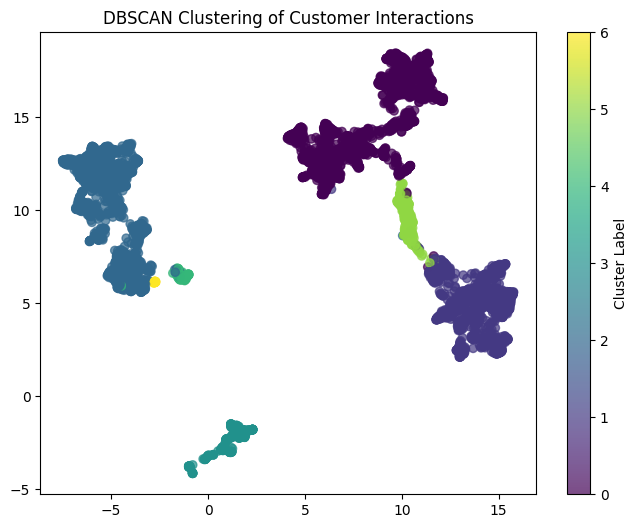

In [17]:
# Reduce embeddings to 2D for visualization
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=cluster_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster Label")
plt.title("DBSCAN Clustering of Customer Interactions")
plt.show()


### Labeling Clusters

To ensure accurate categorization of customer inquiries, we analyzed representative utterances from each cluster and used TF-IDF to identify the most relevant keywords.

In [18]:
# Define a dictionary mapping cluster numbers to topic lables
cluster_label_dic = {
    0: "credit card charge/address update",
    1: "lost or stolen credit card",
    2: "money transfer request",
    3: "customer unresponsive",
    4: "close account",
    5: "loan request",
    6: "check balance/order cheque"
}

# Replace cluster numbers with topic labels
df['topic'] = df['cluster'].map(cluster_label_dic)

df.head()

,conversation_id,utterance,sentiment_score,cluster,cleaned_utterance,topic
0,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,agent: hey may help today customer: hi want change address associated credit card agent: ill glad assist agent: may know name please customer: raju agent: thank raju could let know last 4 digit ssn last 4 digit account number please customer: 5874 3698 agent: may know new address well customer: 1354 sakthi street agent: awesome kindly give minute customer: ya sure agent: thank much staying connected address updated shall receive bank alert updated address customer: hmmm ok agent: may know concern customer: concern thanks effort agent: thank reaching u pleasure assisting,0.9896,0,: hey may today : want change address associated credit card : ill glad assist : may name : raju : raju could let last 4 digit ssn last 4 digit account number : 5874 3698 : may new address well : 1354 sakthi street : awesome kindly give minute : ya : much staying connected address updated shall receive bank alert updated address : hmmm : may concern : concern effort : reaching u pleasure assisting,credit card charge/address update
1,acs-000e0b37-c8f0-46fe-9ffb-0c727e888339-1,agent: hellohow may help today customer: hi need help remove unwanted charge credit card got error report credit card bill agent: oh im sorry hear ill definitely help ensure repeated customer: ok detail required clear issue agent: may please know first last name customer: fill name clement customer: full name clement agent: awesome also may please know last four digit ssn customer: last four digit ssn number 7883 agent: id also require complete credit card number customer: credit card number 73156899867983 agent: thank could help date amount charge customer: charged amount dollar65 date 05172018 time 130 pm agent: thank much bringing notice ill ensure ill raise request delete charge kindly give u 2448 hour get resolved also receiving confirmation email resolved customer: ok thanks agent: welcome would anything else may help customer: yesneed change new address saving account agent: sure may know new address customer: new address 85 five way building newly new film street dc agent: hank sharing information processed request change address shall shortly receive confirmation email customer: ok thanks agent: welcome may confirm question answered today customer: yes thanks timely support agent: always pleasure assisting valuable customer like great day ahead looking forward seeing soon customer: thanks agent: goodbye customer: goodbye,0.9977,0,: hellohow may today : need remove unwanted charge credit card got error report credit card bill : im hear ill definitely ensure repeated : detail required clear issue : may first last name : fill name clement : full name clement : awesome also may last four digit ssn : last four digit ssn number 7883 : id also require complete credit card number : credit card number 73156899867983 : could date amount charge : charged amount dollar65 date 05172018 time 130 pm : much bringing notice ill ensure ill raise request delete charge kindly give u 2448 hour get resolved also receiving confirmation email resolved : : would anything else may : yesneed change new address saving account : may new address : new address 85 five way building newly new film street dc : hank sharing information processed request change address shall shortly receive confirmation email : : may confirm question answered today : timely support : always pleasure assisting valuable like day ahead looking forward seeing soon : : :,credit card charge/address update
2,acs-000efddb-1d74-4422-808e-1b4ccbf988f1-1,customer: good morning agent: good morning may help today customer: lost card safe money agent: sure worry money safe could please help full name credit card number last 4 digit ssn customer: amulassn5240credit card number5426842765274162 agent: okay amul could also please tell card last used police report filed customer: 06272018time1927i file report agent: good know

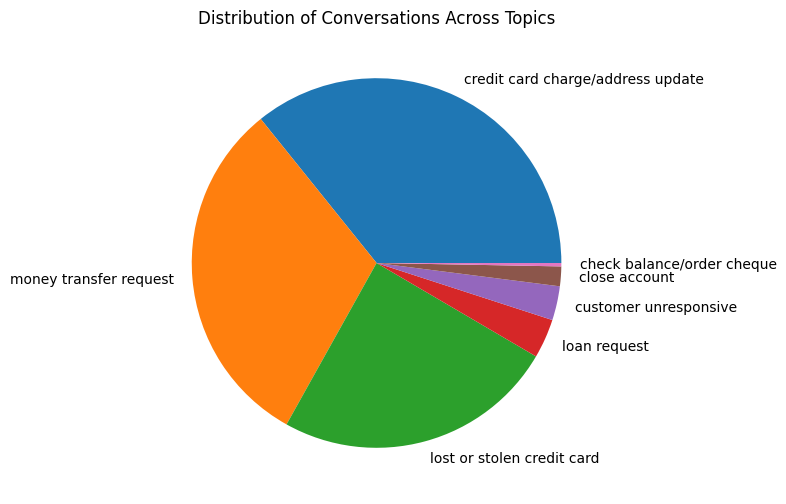

In [19]:
# Create a pie chart to show the distribution of conversations across topics
topic_counts = df['topic'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(topic_counts, labels=topic_counts.index)
plt.title("Distribution of Conversations Across Topics")

plt.show()


## Save The Final Dataset

In [20]:
# Save the dataset
df.to_csv('drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/final_data.csv', index=False)

## Summary

This notebook focuses on categorizing customer inquiries using SBERT embeddings and DBSCAN clustering.

- Generated SBERT embeddings (384D) to represent customer utterances.
- Applied DBSCAN, but initial results had imbalanced clusters and high noise (-1 cluster).
- Reduced dimensions to 10D using UMAP, improving cluster separation and reducing noise.
- Defined cluster labels by reviewing sample utterances and extracting top TF-IDF keywords.
- Visualized results with a pie chart, showing the distribution of inquiries across clusters.